# Fire Detection



In [ ]:
#@title Run this to download the dataset
%%capture
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"

!kaggle datasets download -d ritupande/fire-detection-from-cctv
!unzip -qn \*.zip
!rm -r /content/data/data
!rm -r /content/data/video_data

# Dataset Preparation



In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

SEED = 1
import tensorflow
tensorflow.random.set_seed(SEED)
np.random.seed(SEED)

#1
def _list_dataset(parent_dir):
    
    #Hos.listdir lists the names of all the files in a given folder, you need the full path not just the names so you can load the images
    list_image_names_default = [parent_dir + '/default/' + dir for dir in os.listdir(parent_dir + '/default/')]
    list_labels_default = [0] * len(list_image_names_default)
    list_image_names_fire = [parent_dir + '/fire/' + dir for dir in os.listdir(parent_dir + '/fire/')]
    list_labels_fire = [1] * len(list_image_names_fire)
    list_image_names_smoke = [parent_dir + '/smoke/' + dir for dir in os.listdir(parent_dir + '/smoke/')]
    list_labels_smoke = [2] * len(list_image_names_smoke)
    #join the three lists
    image_names = list_image_names_default + list_image_names_fire + list_image_names_smoke
    labels = list_labels_default + list_labels_fire + list_labels_smoke
    return image_names,labels

#2
def load_dataset(train_path, test_path):
   
    #load train image names and labels
    train_images,train_labels=_list_dataset(train_path)
    #load test image names and labels
    test_images,test_labels=_list_dataset(test_path)
    #join the two subsets to have the full dataset
    images,labels=train_images + test_images, train_labels + test_labels
    #store labels in a Numpy array
    labels_np=np.array(labels)
    #one-hot encoding of the labels
    labels_hot=tensorflow.keras.utils.to_categorical(labels_np, num_classes=3)
    #Prepare images: read, resize to 224x224 and normalize them so that pixel values are grey scaled between 0 and 1. Images must be stored in a Numpy array
    scaled_images=list()
    for img in images:
      img = cv2.imread(img, cv2.IMREAD_UNCHANGED)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
      img=cv2.resize(img,(224,224))
      img=img/255.0
      scaled_images.append(img)
    scaled_np=np.array(scaled_images)

    #shuffle them since we loaded them in order
    X, y = shuffle(scaled_np, labels_hot, random_state=SEED)
    return X,y

In [ ]:
from sklearn.model_selection import train_test_split
train_dir = '/content/data/img_data/train'
test_dir = '/content/data/img_data/test'

#Load the dataset
X,y= load_dataset(train_dir,test_dir)
print("Dimensions of the data:",X.shape,y.shape)

#Train test split
(X_train,X_test,y_train,y_test) = train_test_split(X,y,test_size=0.3)
#Print shapes...
print("Dimensions of the training data:",X_train.shape,y_train.shape)
print("Dimensions of the testing data:",X_test.shape,y_test.shape)

Dimensions of the data: (864, 224, 224) (864, 3)
Dimensions of the training data: (604, 224, 224) (604, 3)
Dimensions of the testing data: (260, 224, 224) (260, 3)


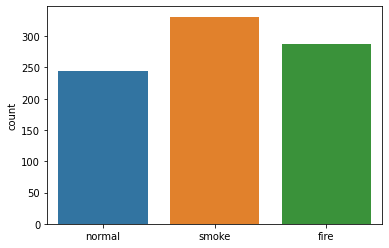

In [ ]:
import seaborn as sns

ax = sns.countplot(x=np.argmax(y, axis=1))
ax.set(xticklabels=['normal', 'smoke', 'fire']);

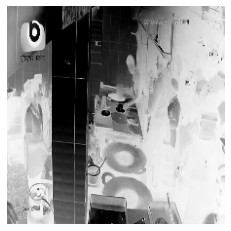

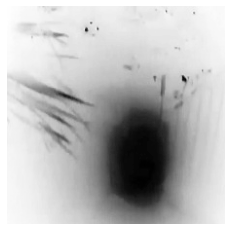

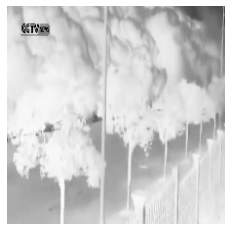

In [ ]:
C0=[]
C1=[]
C2=[]
for i in range(X_train.shape[0]):
  if y_train[i][0]==1:
    C0.append(X_train[i])
  elif y_train[i][1]==1:
    C1.append(X_train[i])
  else:
    C2.append(X_train[i])

#Label 0 (default):
img0=C0[46]
plt.figure()
plt.axis('off')
plt.imshow(img0, cmap='Greys')
plt.show()
#Label 1 (smoke):
img1=C1[23]
plt.figure()
plt.axis('off')
plt.imshow(img1, cmap='Greys')
plt.show()
#Label 2 (fire):
img2=C2[79]
plt.figure()
plt.axis('off')
plt.imshow(img2, cmap='Greys')
plt.show()

# Fully Connected Neural Network



In [ ]:
print("Train Image shape before flattening: ",X_train.shape)
print("Test Image shape before flattening: ",X_test.shape)

X_trainf = X_train.reshape(X_train.shape[0], 224*224)
X_testf = X_test.reshape(X_test.shape[0], 224*224)

print("Train Image shape after flattening: ",X_trainf.shape)
print("Test Image shape after flattening: ",X_testf.shape)

#Building the model
hidden_units=[512,128,128] #number of neurons in each of the 3 hidden layers
out_units = 3 #number of neurons in the output layer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.backend import clear_session

clear_session()

model = Sequential()
model.add(Dense(units=hidden_units[0], activation='relu', input_shape=(50176,))) #first layer with 512 neurons and 50176 inputs

for layer in range(1, len(hidden_units)):
    model.add(Dense(units=hidden_units[layer], activation='relu'))

model.add(Dense(out_units, activation='softmax')) #output layer with 3 neurons

model.summary()


Train Image shape before flattening:  (604, 224, 224)
Test Image shape before flattening:  (260, 224, 224)
Train Image shape after flattening:  (604, 50176)
Test Image shape after flattening:  (260, 50176)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               25690624  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 25,773,187
Trainable params: 25,773,187
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#compile model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy']) #stochastic gradient descent

Epoch 1/15
5/5 [==============================] - 0s 34ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.2998 - val_accuracy: 0.9091
Epoch 2/15
5/5 [==============================] - 0s 29ms/step - loss: 0.0174 - accuracy: 1.0000 - val_loss: 0.3108 - val_accuracy: 0.9091
Epoch 3/15
5/5 [==============================] - 0s 26ms/step - loss: 0.0159 - accuracy: 1.0000 - val_loss: 0.3030 - val_accuracy: 0.9091
Epoch 4/15
5/5 [==============================] - 0s 27ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.3092 - val_accuracy: 0.9091
Epoch 5/15
5/5 [==============================] - 0s 28ms/step - loss: 0.0158 - accuracy: 1.0000 - val_loss: 0.3099 - val_accuracy: 0.9091
Epoch 6/15
5/5 [==============================] - 0s 27ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.3108 - val_accuracy: 0.9091
Epoch 7/15
5/5 [==============================] - 0s 30ms/step - loss: 0.0163 - accuracy: 0.9979 - val_loss: 0.3153 - val_accuracy: 0.9091
Epoch 8/15
5/5 [===========

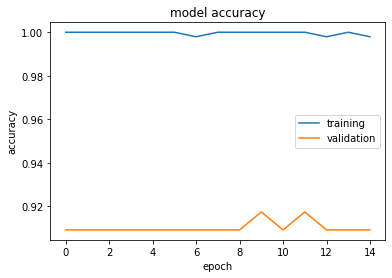

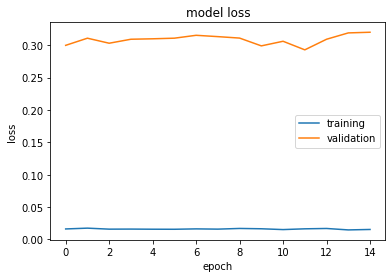

Validation loss: 0.427
Validation accuracy: 0.908


In [ ]:
#Fit Model
history = model.fit(X_trainf, y_train,batch_size=100, epochs=15, validation_split=0.2) #20% of the data is for validation
loss, accuracy  = model.evaluate(X_testf, y_test, verbose=False)

plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

print(f'Validation loss: {loss:.3}')
print(f'Validation accuracy: {accuracy:.3}')

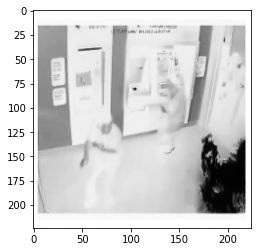

In [ ]:
from sklearn.metrics import classification_report

id=250
test_img=X_testf[id]
plt.imshow(X_test[id], cmap='Greys')

In [ ]:
y_test[id]

array([0., 1., 0.], dtype=float32)

In [ ]:
model.predict(np.expand_dims(test_img, axis=0))

array([[0.02717546, 0.9714225 , 0.00140202]], dtype=float32)

In [ ]:
y_predict = np.around(model.predict(X_testf))
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.91      0.86      0.89        72
           1       0.98      0.90      0.94       107
           2       0.83      0.94      0.88        81

   micro avg       0.91      0.90      0.90       260
   macro avg       0.91      0.90      0.90       260
weighted avg       0.91      0.90      0.90       260
 samples avg       0.90      0.90      0.90       260



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
